In [1]:
import os
import openai
import tiktoken

In [2]:
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv())

open.api_key = os.environ['OPENAI_API_KEY']

In [15]:
def complete_gpt_sentences(prompt, 
                           model="gpt-3.5-turbo",
                           temperature=0.7, 
                           max_tokens=100, 
                           stop=["."]):
    
    user_prompt = f"Here is the first half of a sentence: '{prompt}'. 
    Complete it with one full sentence that is either a noun phrase or a sentential complement, not both. 
    A sentential complement is a clause that follows and completes the meaning of the main verb. 
    Generate the full sentence only."
    messages = [{'role': 'user', 'content': user_prompt}]
    response = openai.chat.completions.create(
        model=model,
        messages=messages,
        temperature=temperature,
        max_tokens=max_tokens,
        stop=stop
    )
    
    return response.choices[0].message.content

with open("no_cue_prompts.txt") as prompts_file:
    prompts = prompts_file.readlines()

    sentences_gpt = []
    for prompt in prompts:
        complete_sentence = complete_gpt_sentences(prompt.strip())
        sentences_gpt.append(complete_sentence)
        print(complete_sentence)

S: 'The employees understood the contract was legally binding
NP completion: The mechanic accepted the car with a faulty transmission
S: The old man recalled the nurse was the one who held his hand during his darkest days in the hospital
The traveller heard the clock strike midnight
S: 'The worker maintained the walls were in good condition
S: The apprentice forgot the bicycle was his only mode of transportation
The committee mentioned the issue that had been causing tension among the team
S: The army found the supplies were already taken by the enemy
The umpire warned the spectators to refrain from disruptive behavior
S: of the bustling city streets with vibrant colors and dynamic brushstrokes
S: 'The teacher explained the concept was difficult for some students to grasp
The gardener observed the plants blooming beautifully in the morning sun
The chef tasted the sauce to see if it needed more salt
The detective uncovered the clue that led to the arrest of the suspect
The author finish

In [16]:
with open('gpt_sentences.txt', 'w') as f:
    for line in sentences_gpt:
        f.write("%s\n" % line)

In [18]:
import spacy
from spacy import displacy
from pathlib import Path

In [19]:
nlp = spacy.load("en_core_web_sm")

In [ ]:
with open('gpt_sentences.txt') as gpt_output:
    for line in gpt_output:
        sentence = line.strip()
        doc = nlp(sentence)
        displacy.render(doc, style="dep")

        for token in doc:
            print(f"{token.text}: {token.dep_} from {token.head.text}")
        
        
        has_sentential_complement = any(token.dep_ in ["ccomp", "xcomp"] for token in doc)
        print(f"Has Sentential Complement: {has_sentential_complement}")

In [55]:
def categorize_sentences(messages,
                model="gpt-3.5-turbo",
                temperature=0,
                max_tokens=3000):
    response = openai.chat.completions.create(
        model=model,
        messages=messages,
        temperature=temperature,
        max_tokens=max_tokens,
    )
    return response.choices[0].message.content

In [23]:
with open ("gpt_sentences.txt") as sentences: 
    sentences = ',\n'.join([
        f'{{"sentence": "{sentence}", "is_NP": true/false, "is_S": true/false}}'
        for sentence in sentences
    ])

system_message = """
Classify each sentence based on its grammatical structure by determining whether each sentence is a noun phrase (is_NP), 
or a sentential complement (is_S). 
A noun phrase acts as the direct object of the main verb, while a sentential complement acts as the embedded subject in an upcoming 
subordinate clause, introduced by conjunctions like "that" and often related to thoughts, speech, perception, or feelings. 
For example, in "She said that she was happy," "that she was happy" is a sentential complement.

Please provide your classification for each sentence in the JSON format, marking 'true' for the category that applies and 
'false' for those that do not. Each sentence should be classified into only one category.
Format for classification:

{
    "sentences": [
        """ + sentences + """
    ]
}
"""

messages = [
    {'role': 'system', 'content': system_message}
]

response = categorize_sentences(messages)
with open("gpt_output.json", "w") as file:
    file.write(response)

In [19]:
import nltk
from nltk import FreqDist
from nltk.tokenize import word_tokenize
import re
import json

In [20]:
with open("gpt_output.json") as gpt_sentences:    
    data = json.load(gpt_sentences)
    
    with open('np_gpt.txt', 'w') as f: 
        for sentence in data['sentences']:
            is_NP = sentence['is_NP']
            if is_NP:
                sentences = sentence['sentence'] 
                f.write("%s\n" % sentences)
                
    with open('s_gpt.txt', 'w') as f: 
        for sentence in data['sentences']:
            is_S = sentence['is_S']
            if is_S:
                sentences = sentence['sentence'] 
                f.write("%s\n" % sentences)

In [21]:
with open ("np_gpt.txt") as np_sentences, open ("s_gpt.txt") as s_sentences:
    gpt_np_sentences = np_sentences.read().lower()
    gpt_s_sentences = s_sentences.read().lower()
    
    gpt_np_tokens = nltk.word_tokenize(gpt_np_sentences)
    fdist_np_gpt = FreqDist(gpt_np_tokens)
    re_pattern = r'\w+'
    gpt_np_clean = []
    
    gpt_s_tokens = nltk.word_tokenize(gpt_s_sentences)
    fdist_s_gpt = FreqDist(gpt_s_tokens)
    re_pattern = r'\w+'
    gpt_s_clean = []
    
    for word in gpt_np_tokens:
        if re.match(re_pattern, word):
            gpt_np_clean.append(word)
            
    for word in gpt_s_tokens:
        if re.match(re_pattern, word):
            gpt_s_clean.append(word)

In [22]:
print(len(gpt_s_clean))

78


In [23]:
print(len(gpt_np_clean))

484


In [24]:
fdist_s_gpt.most_common(10)

[('the', 17),
 ('was', 4),
 ('his', 3),
 ('in', 2),
 ('were', 2),
 ('employees', 1),
 ('understood', 1),
 ('contract', 1),
 ('legally', 1),
 ('binding', 1)]

In [25]:
fdist_np_gpt.most_common(10)

[('the', 108),
 ('that', 13),
 ('to', 11),
 ('of', 10),
 ('with', 6),
 ('for', 5),
 ('and', 4),
 ('it', 4),
 ('was', 4),
 ('his', 4)]

In [26]:
open.api_key = os.environ['ANTHROPIC_API_KEY']
import anthropic

In [16]:
import time

def complete_sentences_claude(prompt):
    message = anthropic.Anthropic().messages.create(
        model="claude-3-haiku-20240307",
        temperature=0.7,
        max_tokens=100,
        stop_sequences=["."],
        messages=[
            {"role": "user", 
             "content": f"Here is the first half of a sentence: '{prompt}'. Complete it with one full sentence that is either a noun phrase or a sentential complement, not both. A sentential complement completion means that the first half of the sentence needs to be followed by a verb that takes a sentential complement. Generate the full sentence only."
            }
             ]
    )
    return message.content[0].text

with open("no_cue_prompts.txt") as prompts_file:
    prompts = prompts_file.readlines()   
    sentences_claude = []
    
    for prompt in prompts:
        complete_sentence = complete_sentences_claude(prompt.strip())
        sentences_claude.append(complete_sentence)
        print(complete_sentence)
        time.sleep(15)

The employees understood the contract that they had signed last month
The mechanic accepted the car that the customer had brought in for repairs
The old man recalled the nurse had been very kind to him during his stay in the hospital
The traveller heard the clock strike midnight
The worker maintained the walls until they were spotless
The apprentice forgot the bicycle that he had left in the garage
The committee mentioned the issue that the project was over budget
The army found the supplies that had been hidden in the warehouse
The umpire warned the spectators that they should not interfere with the game
The artist captured the essence of the sunset
The teacher explained the concept that the students had difficulty understanding
The gardener observed the plants thriving in the warm sunlight
The chef tasted the sauce and found it to be perfectly seasoned
The detective uncovered the clue that the suspect had hidden in the bushes
The author finished the chapter that was well-received by 

In [17]:
with open('claude_sentences.txt', 'w') as f:
    for line in sentences_claude:
        f.write("%s\n" % line)

In [18]:
def categorize_claude_sentences():
    message = anthropic.Anthropic().messages.create(
        model="claude-3-haiku-20240307",
        temperature=0,
        max_tokens=3000,
        stop_sequences=["."],
        messages=[
            {"role": "user", 
             "content": system_message}
        ]
    )
    return message.content[0].text

with open ("claude_sentences.txt") as sentences: 
    sentences = ',\n'.join([
        f'{{"sentence": "{sentence}", "is_NP": true/false, "is_S": true/false}}'
        for sentence in sentences
    ])

system_message = """
Classify each sentence based on its grammatical structure by determining whether each sentence is a noun phrase (is_NP), 
or a sentential complement (is_S). 
A noun phrase acts as the direct object of the main verb, while a sentential complement acts as the embedded subject in an upcoming 
subordinate clause, introduced by conjunctions like "that" and often related to thoughts, speech, perception, or feelings. 
For example, in "She said that she was happy," "that she was happy" is a sentential complement.

Please provide your classification for each sentence in the JSON format, marking 'true' for the category that applies and 
'false' for those that do not. Each sentence should be classified into only one category.
Format for classification:

{
    "sentences": [
        """ + sentences + """
    ]
}
"""

response = categorize_claude_sentences()
with open("claude_output.json", "w") as file:
    file.write(response)

In [36]:
with open("claude_output.json") as claude_sentences:    
    data = json.load(claude_sentences)
    
    with open('np_claude.txt', 'w') as f: 
        for sentence in data['sentences']:
            is_NP = sentence['is_NP']
            if is_NP:
                sentences = sentence['sentence'] 
                f.write("%s\n" % sentences)
                
    with open('s_claude.txt', 'w') as f: 
        for sentence in data['sentences']:
            is_S = sentence['is_S']
            if is_S:
                sentences = sentence['sentence'] 
                f.write("%s\n" % sentences)

In [37]:
with open ("np_claude.txt") as np_sentences, open ("s_claude.txt") as s_sentences:
    claude_np_sentences = np_sentences.read().lower()
    claude_s_sentences = s_sentences.read().lower()
    
    claude_np_tokens = nltk.word_tokenize(claude_np_sentences)
    fdist_np_claude = FreqDist(claude_np_tokens)
    re_pattern = r'\w+'
    claude_np_clean = []
    
    claude_s_tokens = nltk.word_tokenize(claude_s_sentences)
    fdist_s_claude = FreqDist(claude_s_tokens)
    re_pattern = r'\w+'
    claude_s_clean = []
    
    for word in claude_np_tokens:
        if re.match(re_pattern, word):
            claude_np_clean.append(word)
            
    for word in claude_s_tokens:
        if re.match(re_pattern, word):
            claude_s_clean.append(word)

In [38]:
print(len(claude_s_clean))

129


In [39]:
print(len(claude_np_clean))

434


In [40]:
fdist_np_claude.most_common(10)

[('the', 112),
 ('that', 20),
 ('had', 9),
 ('was', 9),
 ('in', 7),
 ('for', 6),
 ('to', 5),
 ('a', 3),
 ('with', 3),
 ('student', 3)]

In [41]:
fdist_s_claude.most_common(10)

[('the', 29),
 ('to', 4),
 ('and', 4),
 ('that', 3),
 ('found', 3),
 ('it', 3),
 ('was', 3),
 ('they', 2),
 ('were', 2),
 (',', 2)]

In [42]:
gpt_count_np = 0
gpt_count_s = 0

with open("np_gpt.txt") as gpt_np, open("s_gpt.txt") as gpt_s:
    for line in gpt_np:
        gpt_count_np += 1
    for line in gpt_s:
        gpt_count_s += 1

claude_count_np = 0
claude_count_s = 0

with open("np_claude.txt") as claude_np, open("s_claude.txt") as claude_s:
    for line in claude_np:
        claude_count_np += 1 
    for line in claude_s:
        claude_count_s += 1

In [43]:
from matplotlib import pyplot as plt
import numpy as np

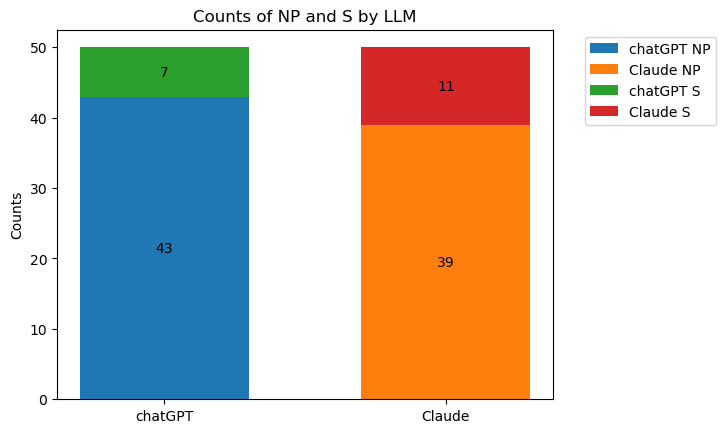

In [44]:
count_np = {
    'chatGPT': gpt_count_np,  
    'Claude': claude_count_np 
}
count_s = {
    'chatGPT': gpt_count_s,  
    'Claude': claude_count_s
}

LLMs = ['chatGPT', 'Claude']

width = 0.6
fig, ax = plt.subplots()

x = np.arange(len(LLMs))

bottom_np = np.zeros(len(LLMs))
bottom_s = np.zeros(len(LLMs))

for i, (LLM, count) in enumerate(count_np.items()):
    bars = ax.bar(x[i], count, width, label='{} NP'.format(LLM))
    bottom_np[i] += count
    ax.bar_label(bars, label_type='center')

for i, (LLM, count) in enumerate(count_s.items()):
    bars = ax.bar(x[i], count, width, label='{} S'.format(LLM), bottom=bottom_np[i])
    bottom_s[i] += count
    ax.bar_label(bars, label_type='center')

ax.set_ylabel('Counts')
ax.set_title('Counts of NP and S by LLM')
ax.set_xticks(x)
ax.set_xticklabels(LLMs)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

In [52]:
def complete_gpt_sentences(prompt, 
                           model="gpt-3.5-turbo",
                           temperature=0.7, 
                           max_tokens=100, 
                           stop=["."]):
    
    user_prompt = f"Here is the first half of a sentence: '{prompt}'. Complete it with one full sentence that is either a noun phrase or a sentential complement, not both. A sentential complement completion means that the first half of the sentence needs to be followed by a verb that takes a sentential complement. Generate the full sentence only."
    
    messages = [{'role': 'user', 'content': user_prompt}]
    response = openai.chat.completions.create(
        model=model,
        messages=messages,
        temperature=temperature,
        max_tokens=max_tokens,
        stop=stop
    )
    
    return response.choices[0].message.content

with open("no_cue_prompts.txt") as prompts_file:
    prompts = prompts_file.readlines()

    sentences_gpt2 = []
    for prompt in prompts:
        complete_sentence = complete_gpt_sentences(prompt.strip())
        sentences_gpt2.append(complete_sentence)
        print(complete_sentence)

The employees understood the contract terms
The mechanic accepted the car with a grateful smile
The old man recalled the nurse who had cared for him during his recovery
The traveller heard the clock chiming in the distance
The worker maintained the walls with a fresh coat of paint
The apprentice forgot the bicycle at the park
The committee mentioned the issue during their weekly meeting
The army found the supplies hidden in the remote cave
The umpire warned the spectators to stop throwing objects onto the field
The artist captured the essence of tranquility in his painting
The teacher explained the concept clearly and concisely
The gardener observed the plants growing beautifully in the morning sun
The chef tasted the sauce and immediately added more salt
The detective uncovered the clue, leading to a breakthrough in the case
The author finished the chapter with a sense of accomplishment
The programmer debugged the software successfully
The historian researched the era of the Roman Emp

In [53]:
with open('gpt_sentences2.txt', 'w') as f:
    for line in sentences_gpt2:
        f.write("%s\n" % line)

In [56]:
with open ("gpt_sentences2.txt") as sentences: 
    sentences = ',\n'.join([
        f'{{"sentence": "{sentence}", "is_NP": true/false, "is_S": true/false}}'
        for sentence in sentences
    ])

system_message = """
Classify each sentence based on its grammatical structure by determining whether each sentence is a noun phrase (is_NP), 
or a sentential complement (is_S). 
A noun phrase acts as the direct object of the main verb, while a sentential complement acts as the embedded subject in an upcoming 
subordinate clause, introduced by conjunctions like "that" and often related to thoughts, speech, perception, or feelings. 
For example, in "She said that she was happy," "that she was happy" is a sentential complement.

Please provide your classification for each sentence in the JSON format, marking 'true' for the category that applies and 
'false' for those that do not. Each sentence should be classified into only one category.
Format for classification:

{
    "sentences": [
        """ + sentences + """
    ]
}
"""

messages = [
    {'role': 'system', 'content': system_message}
]

response = categorize_sentences(messages)
with open("gpt_output2.json", "w") as file:
    file.write(response)

In [57]:
with open("gpt_output2.json") as gpt_sentences2:    
    data = json.load(gpt_sentences2)
    
    with open('np_gpt2.txt', 'w') as f: 
        for sentence in data['sentences']:
            is_NP = sentence['is_NP']
            if is_NP:
                sentences = sentence['sentence'] 
                f.write("%s\n" % sentences)
                
    with open('s_gpt2.txt', 'w') as f: 
        for sentence in data['sentences']:
            is_S = sentence['is_S']
            if is_S:
                sentences = sentence['sentence'] 
                f.write("%s\n" % sentences)

In [58]:
with open("no_cue_prompts.txt") as prompts_file:
    prompts = prompts_file.readlines()   
    sentences_claude2 = []
    
    for prompt in prompts:
        complete_sentence = complete_sentences_claude(prompt.strip())
        sentences_claude2.append(complete_sentence)
        print(complete_sentence)
        time.sleep(15)

The employees understood the contract that the company had presented to them
The mechanic accepted the car that was in need of a tune-up
The old man recalled the nurse who had cared for him during his illness
The traveller heard the clock strike midnight
The worker maintained the walls until they were spotless
The apprentice forgot the bicycle that he had left at the park
The committee mentioned the issue that the project was behind schedule
The army found the supplies hidden in the abandoned warehouse
The umpire warned the spectators that their behavior was unacceptable
The artist captured the essence of the landscape
The teacher explained the concept that the students had been struggling with
The gardener observed the plants were thriving in the sunlight
The chef tasted the sauce and found it to be too salty
The detective uncovered the clue that the victim had been murdered the previous night
The author finished the chapter after weeks of tireless writing
The programmer debugged the 

In [59]:
with open('claude_sentences2.txt', 'w') as f:
    for line in sentences_claude2:
        f.write("%s\n" % line)

In [60]:
def categorize_claude_sentences():
    message = anthropic.Anthropic().messages.create(
        model="claude-3-haiku-20240307",
        temperature=0,
        max_tokens=3000,
        stop_sequences=["."],
        messages=[
            {"role": "user", 
             "content": system_message}
        ]
    )
    return message.content[0].text

with open ("claude_sentences2.txt") as sentences: 
    sentences = ',\n'.join([
        f'{{"sentence": "{sentence}", "is_NP": true/false, "is_S": true/false}}'
        for sentence in sentences
    ])

system_message = """
You will be provided with a list of sentences.
For each sentence, classify whether it is a noun phrase (is_NP) or a sentential complement (is_S).
NP acts as the direct object of the main verb, while S acts as the embedded subject in an upcoming subordinate clause.
Provide the output in JSON format with the following structure:

{
    "sentences": [
        """ + sentences + """
    ]
}
"""

response = categorize_claude_sentences()
with open("claude_output2.json", "w") as file:
    file.write(response)

In [61]:
with open("claude_output2.json") as claude_sentences2:    
    data = json.load(claude_sentences2)
    
    with open('np_claude2.txt', 'w') as f: 
        for sentence in data['sentences']:
            is_NP = sentence['is_NP']
            if is_NP:
                sentences = sentence['sentence'] 
                f.write("%s\n" % sentences)
                
    with open('s_claude2.txt', 'w') as f: 
        for sentence in data['sentences']:
            is_S = sentence['is_S']
            if is_S:
                sentences = sentence['sentence'] 
                f.write("%s\n" % sentences)

In [62]:
gpt_count_np2 = 0
gpt_count_s2 = 0

with open("np_gpt2.txt") as gpt_np2, open("s_gpt2.txt") as gpt_s2:
    for line in gpt_np2:
        gpt_count_np2 += 1
    for line in gpt_s2:
        gpt_count_s2 += 1

claude_count_np2 = 0
claude_count_s2 = 0

with open("np_claude2.txt") as claude_np2, open("s_claude2.txt") as claude_s2:
    for line in claude_np2:
        claude_count_np2 += 1 
    for line in claude_s2:
        claude_count_s2 += 1

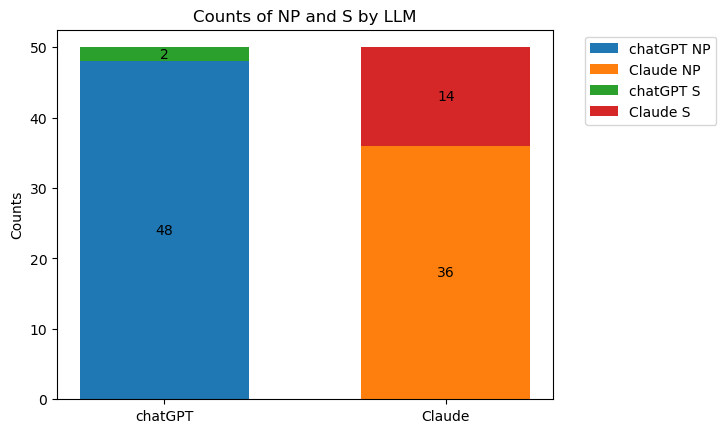

In [63]:
count_np2 = {
    'chatGPT': gpt_count_np2,  
    'Claude': claude_count_np2
}
count_s2 = {
    'chatGPT': gpt_count_s2,  
    'Claude': claude_count_s2
}

LLMs = ['chatGPT', 'Claude']

width = 0.6
fig, ax = plt.subplots()

x = np.arange(len(LLMs))

bottom_np = np.zeros(len(LLMs))
bottom_s = np.zeros(len(LLMs))

for i, (LLM, count) in enumerate(count_np2.items()):
    bars = ax.bar(x[i], count, width, label='{} NP'.format(LLM))
    bottom_np[i] += count
    ax.bar_label(bars, label_type='center')

for i, (LLM, count) in enumerate(count_s2.items()):
    bars = ax.bar(x[i], count, width, label='{} S'.format(LLM), bottom=bottom_np[i])
    bottom_s[i] += count
    ax.bar_label(bars, label_type='center')

ax.set_ylabel('Counts')
ax.set_title('Counts of NP and S by LLM')
ax.set_xticks(x)
ax.set_xticklabels(LLMs)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

In [68]:
with open("no_cue_prompts.txt") as prompts_file:
    prompts = prompts_file.readlines()

    sentences_gpt3 = []
    for prompt in prompts:
        complete_sentence = complete_gpt_sentences(prompt.strip())
        sentences_gpt3.append(complete_sentence)
        print(complete_sentence)

The employees understood the contract was written in legal jargon
The mechanic accepted the car for repairs
The old man recalled the nurse from his time in the hospital
The traveller heard the clock ticking in the distance
The worker maintained the walls with a fresh coat of paint
The apprentice forgot the bicycle at the park
The committee mentioned the issue in their monthly report
The army found the supplies hidden in the underground bunker
"The umpire warned the spectators to stop throwing objects onto the field
The artist captured the essence of love in their painting
The teacher explained the concept in great detail
The gardener observed the plants withering in the harsh sunlight
The chef tasted the sauce and immediately knew it needed more salt
The detective uncovered the clue that led to the suspect's arrest
The author finished the chapter and celebrated with a glass of wine
The programmer debugged the software successfully
The historian researched the era's impact on modern soc

In [69]:
with open('gpt_sentences3.txt', 'w') as f:
    for line in sentences_gpt3:
        f.write("%s\n" % line)

In [70]:
with open ("gpt_sentences3.txt") as sentences: 
    sentences = ',\n'.join([
        f'{{"sentence": "{sentence}", "is_NP": true/false, "is_S": true/false}}'
        for sentence in sentences
    ])

system_message = """
Classify each sentence based on its grammatical structure by determining whether each sentence is a noun phrase (is_NP), 
or a sentential complement (is_S). 
A noun phrase acts as the direct object of the main verb, while a sentential complement acts as the embedded subject in an upcoming 
subordinate clause, introduced by conjunctions like "that" and often related to thoughts, speech, perception, or feelings. 
For example, in "She said that she was happy," "that she was happy" is a sentential complement.

Please provide your classification for each sentence in the JSON format, marking 'true' for the category that applies and 
'false' for those that do not. Each sentence should be classified into only one category.
Format for classification:

{
    "sentences": [
        """ + sentences + """
    ]
}
"""

messages = [
    {'role': 'system', 'content': system_message}
]

response = categorize_sentences(messages)
with open("gpt_output3.json", "w") as file:
    file.write(response)

In [76]:
with open("gpt_output3.json") as gpt_sentences3:    
    data = json.load(gpt_sentences3)
    
    with open('np_gpt3.txt', 'w') as f: 
        for sentence in data['sentences']:
            is_NP = sentence['is_NP']
            if is_NP:
                sentences = sentence['sentence'] 
                f.write("%s\n" % sentences)
                
    with open('s_gpt3.txt', 'w') as f: 
        for sentence in data['sentences']:
            is_S = sentence['is_S']
            if is_S:
                sentences = sentence['sentence'] 
                f.write("%s\n" % sentences)

In [71]:
with open("no_cue_prompts.txt") as prompts_file:
    prompts = prompts_file.readlines()   
    sentences_claude3 = []
    
    for prompt in prompts:
        complete_sentence = complete_sentences_claude(prompt.strip())
        sentences_claude3.append(complete_sentence)
        print(complete_sentence)
        time.sleep(15)

The employees understood the contract that they had signed last month
The mechanic accepted the car because it was in need of repair
The old man recalled the nurse that she had been very kind to him during his stay at the hospital
The traveller heard the clock strike midnight
The worker maintained the walls that were in need of repair
The apprentice forgot the bicycle was locked to the post
The committee mentioned the issue that the new policy had caused significant controversy
The army found the supplies that were hidden in the warehouse
The umpire warned the spectators that they should refrain from throwing objects onto the field
The artist captured the essence of the landscape
The teacher explained the concept that the students had been struggling with
The gardener observed the plants were thriving in the warm weather
The chef tasted the sauce and found it to be perfectly seasoned
The detective uncovered the clue that the suspect had hidden in the bushes
The author finished the chap

In [72]:
with open('claude_sentences3.txt', 'w') as f:
    for line in sentences_claude3:
        f.write("%s\n" % line)

In [73]:
def categorize_claude_sentences():
    message = anthropic.Anthropic().messages.create(
        model="claude-3-haiku-20240307",
        temperature=0,
        max_tokens=3000,
        stop_sequences=["."],
        messages=[
            {"role": "user", 
             "content": system_message}
        ]
    )
    return message.content[0].text

with open ("claude_sentences3.txt") as sentences: 
    sentences = ',\n'.join([
        f'{{"sentence": "{sentence}", "is_NP": true/false, "is_S": true/false}}'
        for sentence in sentences
    ])

system_message = """
You will be provided with a list of sentences.
For each sentence, classify whether it is a noun phrase (is_NP) or a sentential complement (is_S).
NP acts as the direct object of the main verb, while S acts as the embedded subject in an upcoming subordinate clause.
Provide the output in JSON format with the following structure:

{
    "sentences": [
        """ + sentences + """
    ]
}
"""

response = categorize_claude_sentences()
with open("claude_output3.json", "w") as file:
    file.write(response)

In [74]:
with open("claude_output3.json") as claude_sentences2:    
    data = json.load(claude_sentences2)
    
    with open('np_claude3.txt', 'w') as f: 
        for sentence in data['sentences']:
            is_NP = sentence['is_NP']
            if is_NP:
                sentences = sentence['sentence'] 
                f.write("%s\n" % sentences)
                
    with open('s_claude3.txt', 'w') as f: 
        for sentence in data['sentences']:
            is_S = sentence['is_S']
            if is_S:
                sentences = sentence['sentence'] 
                f.write("%s\n" % sentences)

In [77]:
gpt_count_np3 = 0
gpt_count_s3 = 0

with open("np_gpt3.txt") as gpt_np3, open("s_gpt3.txt") as gpt_s3:
    for line in gpt_np3:
        gpt_count_np3 += 1
    for line in gpt_s3:
        gpt_count_s3 += 1

claude_count_np3 = 0
claude_count_s3 = 0

with open("np_claude3.txt") as claude_np3, open("s_claude3.txt") as claude_s3:
    for line in claude_np3:
        claude_count_np3 += 1 
    for line in claude_s3:
        claude_count_s3 += 1

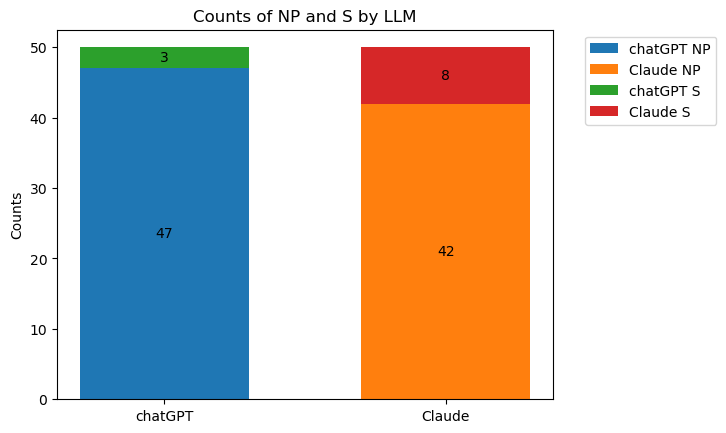

In [78]:
count_np3 = {
    'chatGPT': gpt_count_np3,  
    'Claude': claude_count_np3
}
count_s3 = {
    'chatGPT': gpt_count_s3,  
    'Claude': claude_count_s3
}

LLMs = ['chatGPT', 'Claude']

width = 0.6
fig, ax = plt.subplots()

x = np.arange(len(LLMs))

bottom_np = np.zeros(len(LLMs))
bottom_s = np.zeros(len(LLMs))

for i, (LLM, count) in enumerate(count_np3.items()):
    bars = ax.bar(x[i], count, width, label='{} NP'.format(LLM))
    bottom_np[i] += count
    ax.bar_label(bars, label_type='center')

for i, (LLM, count) in enumerate(count_s3.items()):
    bars = ax.bar(x[i], count, width, label='{} S'.format(LLM), bottom=bottom_np[i])
    bottom_s[i] += count
    ax.bar_label(bars, label_type='center')

ax.set_ylabel('Counts')
ax.set_title('Counts of NP and S by LLM')
ax.set_xticks(x)
ax.set_xticklabels(LLMs)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()